# 1. Import Dependencies

In [32]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Dropout, Flatten, GlobalAveragePooling2D, concatenate, BatchNormalization, Conv2D, Activation
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau, BackupAndRestore
from tensorflow.keras.applications import ResNet50
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import matthews_corrcoef, confusion_matrix
import boto3
from io import BytesIO
import json
import random

# 2. Load Config

In [33]:
# 2. Load Config
# Load configuration from config.json
with open('config.json', 'r') as config_file:
    config = json.load(config_file)

# Set seed
tf.random.set_seed(config["seed"])

# Load configuration values
bucket_name = config["s3_bucket_name"]
train_labels_path = config["train_labels_path"]
test_labels_path = config["test_labels_path"]
train_prefix = config["output_dir_train"]
test_prefix = config["output_dir_test"]
as_gray = config["as_gray"]
img_rows, img_cols = config["img_rows"], config["img_cols"]
channels = config["in_channel"]
num_classes = config["num_classes"]
batch_size = config["batch_size"]
all_epochs = config["all_epochs"]
input_shape = tuple(config["input_shape"])

# Define input shape
input_img = Input(shape=input_shape)

# Initialize S3 client
s3 = boto3.client('s3')

# Helper function to upload numpy arrays to S3
def upload_to_s3(np_array, bucket, key):
    with BytesIO() as buffer:
        np.save(buffer, np_array)
        buffer.seek(0)
        s3.put_object(Bucket=bucket, Key=key, Body=buffer.getvalue())

# Helper function to load numpy arrays from S3
def load_from_s3(bucket, key):
    obj = s3.get_object(Bucket=bucket, Key=key)
    return np.load(BytesIO(obj['Body'].read()))

In [4]:
# Checkpoint, Load train labels
obj = s3.get_object(Bucket=bucket_name, Key=config["train_labels_path"])
train_df = pd.read_excel(BytesIO(obj['Body'].read()))
print("Train data columns:", train_df.columns)
response = s3.list_objects_v2(Bucket=bucket_name, Prefix="CMMD-D2/train/PNGs/")
for obj in response.get('Contents', []):
    print(obj['Key'])


Train data columns: Index(['patient_id', 'L_CC_file', 'L_MLO_file', 'R_CC_file', 'R_MLO_file',
       'subtype', 'target'],
      dtype='object')
CMMD-D2/train/PNGs/D2-0001_L_CC.png
CMMD-D2/train/PNGs/D2-0001_L_MLO.png
CMMD-D2/train/PNGs/D2-0001_R_CC.png
CMMD-D2/train/PNGs/D2-0001_R_MLO.png
CMMD-D2/train/PNGs/D2-0002_L_CC.png
CMMD-D2/train/PNGs/D2-0002_L_MLO.png
CMMD-D2/train/PNGs/D2-0002_R_CC.png
CMMD-D2/train/PNGs/D2-0002_R_MLO.png
CMMD-D2/train/PNGs/D2-0003_L_CC.png
CMMD-D2/train/PNGs/D2-0003_L_MLO.png
CMMD-D2/train/PNGs/D2-0003_R_CC.png
CMMD-D2/train/PNGs/D2-0003_R_MLO.png
CMMD-D2/train/PNGs/D2-0004_L_CC.png
CMMD-D2/train/PNGs/D2-0004_L_MLO.png
CMMD-D2/train/PNGs/D2-0004_R_CC.png
CMMD-D2/train/PNGs/D2-0004_R_MLO.png
CMMD-D2/train/PNGs/D2-0005_L_CC.png
CMMD-D2/train/PNGs/D2-0005_L_MLO.png
CMMD-D2/train/PNGs/D2-0005_R_CC.png
CMMD-D2/train/PNGs/D2-0005_R_MLO.png
CMMD-D2/train/PNGs/D2-0006_L_CC.png
CMMD-D2/train/PNGs/D2-0006_L_MLO.png
CMMD-D2/train/PNGs/D2-0006_R_CC.png
CMMD-D2/train/P

# 3. Load Train Data

In [34]:
# 3. Load Train Data and Combine Views from s3
def read_and_combine_views(left_paths, right_paths, img_rows, img_cols, as_gray, channels, bucket_name, prefix,
                           left_suffix_CC="_L_CC.png", right_suffix_CC="_R_CC.png",
                           left_suffix_MLO="_L_MLO.png", right_suffix_MLO="_R_MLO.png"):
    images_combined_CC = []
    images_combined_MLO = []
    
    for patient_id in left_paths:
        try:
            # Construct S3 keys for left and right CC and MLO images
            left_s3_key_CC = f"{prefix}/PNGs/{patient_id}{left_suffix_CC}"
            right_s3_key_CC = f"{prefix}/PNGs/{patient_id}{right_suffix_CC}"
            left_s3_key_MLO = f"{prefix}/PNGs/{patient_id}{left_suffix_MLO}"
            right_s3_key_MLO = f"{prefix}/PNGs/{patient_id}{right_suffix_MLO}"

            # Fetch and process CC images
            left_obj_CC = s3.get_object(Bucket=bucket_name, Key=left_s3_key_CC)
            left_image_CC = imread(BytesIO(left_obj_CC['Body'].read()), as_gray=as_gray)
            if as_gray and channels == 3:
                left_image_CC = gray2rgb(left_image_CC)
            left_image_CC = resize(left_image_CC, (img_rows, img_cols), anti_aliasing=True)

            right_obj_CC = s3.get_object(Bucket=bucket_name, Key=right_s3_key_CC)
            right_image_CC = imread(BytesIO(right_obj_CC['Body'].read()), as_gray=as_gray)
            if as_gray and channels == 3:
                right_image_CC = gray2rgb(right_image_CC)
            right_image_CC = resize(right_image_CC, (img_rows, img_cols), anti_aliasing=True)

            # Combine CC images
            combined_image_CC = np.stack((left_image_CC, right_image_CC), axis=-1)
            images_combined_CC.append(combined_image_CC)

            # Fetch and process MLO images
            left_obj_MLO = s3.get_object(Bucket=bucket_name, Key=left_s3_key_MLO)
            left_image_MLO = imread(BytesIO(left_obj_MLO['Body'].read()), as_gray=as_gray)
            if as_gray and channels == 3:
                left_image_MLO = gray2rgb(left_image_MLO)
            left_image_MLO = resize(left_image_MLO, (img_rows, img_cols), anti_aliasing=True)

            right_obj_MLO = s3.get_object(Bucket=bucket_name, Key=right_s3_key_MLO)
            right_image_MLO = imread(BytesIO(right_obj_MLO['Body'].read()), as_gray=as_gray)
            if as_gray and channels == 3:
                right_image_MLO = gray2rgb(right_image_MLO)
            right_image_MLO = resize(right_image_MLO, (img_rows, img_cols), anti_aliasing=True)

            # Combine MLO images
            combined_image_MLO = np.stack((left_image_MLO, right_image_MLO), axis=-1)
            images_combined_MLO.append(combined_image_MLO)
        
        except Exception as e:
            print(f"Error loading {left_s3_key_CC}, {right_s3_key_CC}, {left_s3_key_MLO}, or {right_s3_key_MLO}: {e}")
# Convert to numpy arrays and normalize
    images_combined_CC = np.asarray(images_combined_CC, dtype=np.float32)
    images_combined_CC = (images_combined_CC - images_combined_CC.min()) / (images_combined_CC.max() - images_combined_CC.min())

    images_combined_MLO = np.asarray(images_combined_MLO, dtype=np.float32)
    images_combined_MLO = (images_combined_MLO - images_combined_MLO.min()) / (images_combined_MLO.max() - images_combined_MLO.min())
        
    return images_combined_CC, images_combined_MLO


In [35]:
# Load train labels
obj = s3.get_object(Bucket=bucket_name, Key=train_labels_path)
train_df = pd.read_excel(BytesIO(obj['Body'].read()))

# Split the data into training and validation sets
train_df, val_df = train_test_split(train_df, test_size=0.2, random_state=1203)
print("the number of patients in train set is:",len(train_df))
print("the number of patients in val set is:",len(val_df))
print(train_df.head(2))


the number of patients in train set is: 591
the number of patients in val set is: 148
    patient_id                            L_CC_file  \
399    D2-0407  CMMD-D2/train/PNGs/D2-0407_L_CC.png   
565    D2-0574  CMMD-D2/train/PNGs/D2-0574_L_CC.png   

                               L_MLO_file  \
399  CMMD-D2/train/PNGs/D2-0407_L_MLO.png   
565  CMMD-D2/train/PNGs/D2-0574_L_MLO.png   

                               R_CC_file  \
399  CMMD-D2/train/PNGs/D2-0407_R_CC.png   
565  CMMD-D2/train/PNGs/D2-0574_R_CC.png   

                               R_MLO_file    subtype  target  
399  CMMD-D2/train/PNGs/D2-0407_R_MLO.png  Luminal B       0  
565  CMMD-D2/train/PNGs/D2-0574_R_MLO.png  Luminal B       0  


In [36]:
# Data Loading and Preprocessing with Improved Augmentation
train_datagen = ImageDataGenerator(
    rescale=1.0/255,
    rotation_range=40,
    width_shift_range=0.4,
    height_shift_range=0.4,
    shear_range=0.4,
    zoom_range=0.4,
    horizontal_flip=True,
    fill_mode='nearest'
)
validation_datagen = ImageDataGenerator(rescale=1.0/255)

In [37]:
def load_images_from_s3(patient_ids, img_rows, img_cols, bucket_name):
    images = []
    for img_path in patient_ids:
        key = img_path.strip()
        print(f"Attempting to load key: {key}")
        try:
            obj = s3.get_object(Bucket=bucket_name, Key=key)
            img = tf.image.decode_png(obj['Body'].read(), channels=3)
            img = tf.image.resize(img, [img_rows, img_cols])
            images.append(img)
        except s3.exceptions.NoSuchKey as e:
            print(f"Error: Key {key} does not exist.")
    if images:
        return tf.stack(images)
    else:
        raise ValueError("No valid images were loaded.")


In [38]:
# Load training and validation images from S3
img_rows, img_cols = 224, 224

# Load CC and MLO views for both left and right breasts for training and validation
x_train_CC = load_images_from_s3(train_df.L_CC_file.values.tolist() + train_df.R_CC_file.values.tolist(), img_rows, img_cols, bucket_name)
x_train_MLO = load_images_from_s3(train_df.L_MLO_file.values.tolist() + train_df.R_MLO_file.values.tolist(), img_rows, img_cols, bucket_name)

x_val_CC = load_images_from_s3(val_df.L_CC_file.values.tolist() + val_df.R_CC_file.values.tolist(), img_rows, img_cols, bucket_name)
x_val_MLO = load_images_from_s3(val_df.L_MLO_file.values.tolist() + val_df.R_MLO_file.values.tolist(), img_rows, img_cols, bucket_name)

Attempting to load key: CMMD-D2/train/PNGs/D2-0407_L_CC.png
Attempting to load key: CMMD-D2/train/PNGs/D2-0574_L_CC.png
Attempting to load key: CMMD-D2/train/PNGs/D2-0610_L_CC.png
Attempting to load key: CMMD-D2/train/PNGs/D2-0098_L_CC.png
Attempting to load key: CMMD-D2/train/PNGs/D2-0671_L_CC.png
Attempting to load key: CMMD-D2/train/PNGs/D2-0364_L_CC.png
Attempting to load key: CMMD-D2/train/PNGs/D2-0230_L_CC.png
Attempting to load key: CMMD-D2/train/PNGs/D2-0406_L_CC.png
Attempting to load key: CMMD-D2/train/PNGs/D2-0014_L_CC.png
Attempting to load key: CMMD-D2/train/PNGs/D2-0125_L_CC.png
Attempting to load key: CMMD-D2/train/PNGs/D2-0556_L_CC.png
Attempting to load key: CMMD-D2/train/PNGs/D2-0059_L_CC.png
Attempting to load key: CMMD-D2/train/PNGs/D2-0453_L_CC.png
Attempting to load key: CMMD-D2/train/PNGs/D2-0130_L_CC.png
Attempting to load key: CMMD-D2/train/PNGs/D2-0269_L_CC.png
Attempting to load key: CMMD-D2/train/PNGs/D2-0346_L_CC.png
Attempting to load key: CMMD-D2/train/PN

In [39]:
y_train = tf.keras.utils.to_categorical(train_df.target.values, num_classes=2)
y_val = tf.keras.utils.to_categorical(val_df.target.values, num_classes=2)

y_train = tf.keras.utils.to_categorical(train_df.target.values.tolist() * 2, num_classes=2)[:len(x_train_CC)]
y_val = tf.keras.utils.to_categorical(val_df.target.values.tolist() * 2, num_classes=2)[:len(x_val_CC)]


# 4. Define the Model


In [40]:
# Improved Model Definition with Two ResNet50 Base Models for CC and MLO Views
# Input tensors for CC and MLO views
I1 = Input(shape=(img_rows, img_cols, 3))
model1 = ResNet50(weights='imagenet', include_top=False, input_tensor=I1, pooling=None)
MLO_model = Model(inputs=I1, outputs=model1.get_layer('conv4_block6_out').output)

I2 = Input(shape=(img_rows, img_cols, 3))
model2 = ResNet50(weights='imagenet', include_top=False, input_tensor=I2, pooling=None)
for layer in model2.layers:
    layer.name = layer.name + '_2'
CC_model = Model(inputs=I2, outputs=model2.get_layer('conv4_block6_out_2').output)

x_mlo = MLO_model.output
x_cc = CC_model.output

# Combine the outputs from MLO and CC views
c1 = concatenate([x_mlo, x_cc], axis=2)

In [42]:
# Define the final model
x = GlobalAveragePooling2D()(c1)
#x = Dense(512, activation="relu")(x)
#x = Dropout(0.3)(x)
x = Dense(512, activation="relu", kernel_regularizer=tf.keras.regularizers.l2(0.005))(x)  # Added L2 regularization
x = Dropout(0.5)(x)  # Increased dropout rate
output = Dense(num_classes, activation='softmax', name='output')(x)
model = Model(inputs=[MLO_model.input, CC_model.input], outputs=output)

# Compile the model with custom metrics
model.compile(
    optimizer=Adam(learning_rate=0.0001),  # Reduced learning rate for more stable training
    loss='categorical_crossentropy',
    metrics=[
        'accuracy',
        tf.keras.metrics.Precision(name='precision'),
        tf.keras.metrics.Recall(name='recall'),
        tf.keras.metrics.AUC(name='auc')
    ]
)


# Print shapes of x and y to verify dimensions


In [14]:
# Print shapes of x and y to verify dimensions
print(f"x_train_CC shape: {x_train_CC.shape}")
print(f"x_train_MLO shape: {x_train_MLO.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"x_val_CC shape: {x_val_CC.shape}")
print(f"x_val_MLO shape: {x_val_MLO.shape}")
print(f"y_val shape: {y_val.shape}")

x_train_CC shape: (1179, 224, 224, 3)
x_train_MLO shape: (1179, 224, 224, 3)
y_train shape: (1179, 2)
x_val_CC shape: (295, 224, 224, 3)
x_val_MLO shape: (295, 224, 224, 3)
y_val shape: (295, 2)


# Script to randomly check a patient to see if x_data matches with y_data


In [14]:
random_index = random.randint(0, len(x_train_CC) - 1)
x_sample_cc_path = train_df.iloc[random_index]['L_CC_file']
x_sample_mlo_path = train_df.iloc[random_index]['L_MLO_file']
x_sample_cc = x_train_CC[random_index]
print(f"CC Image Path: {x_sample_cc_path}")
x_sample_mlo = x_train_MLO[random_index]
print(f"MLO Image Path: {x_sample_mlo_path}")
y_sample = y_train[random_index]    #[1. 0.] means that the sample belongs to class 0.
                                    #[0. 1.] would mean that the sample belongs to class 1.


print(f"Random Patient Index: {random_index}")
print(f"x_sample_cc shape: {x_sample_cc.shape}")
print(f"x_sample_mlo shape: {x_sample_mlo.shape}")
print(f"y_sample: {y_sample}")
print(train_df.iloc[random_index])


NameError: name 'x_train_CC' is not defined

# Epoch Restoration


In [43]:
# Epoch Restoration
try:
    model.load_weights('best_model.keras')
    print("Loaded weights from previous training session.")
except Exception as e:
    print("No previous weights found. Starting training from scratch.")

# Protect against SSH disconnection
callbacks = [
    ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=5),
    ModelCheckpoint(filepath='best_model.keras', save_best_only=True),
    BackupAndRestore(backup_dir='/tmp/training_backup'),
    EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)  # Added early stopping
]

Loaded weights from previous training session.


/home/ellaquan/.local/lib/python3.11/site-packages/keras/src/saving/saving_lib.py:719: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 698 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


# Train the Model


In [45]:
# Assuming the previous training history is available and you know where to resume
last_epoch = 15  # Replace with the last completed epoch based on your saved history

# Train the Model with epoch restoration
history = model.fit(
    [x_train_MLO, x_train_CC],
    y_train,
    batch_size=32,
    epochs=90,
    validation_data=([x_val_MLO, x_val_CC], y_val),
    callbacks=callbacks,
    shuffle=True,
    initial_epoch=last_epoch  # Resume training from the last completed epoch
)

# Save history to S3
history_dict = history.history
history_json = json.dumps(history_dict)
s3.put_object(Bucket=bucket_name, Key='training_history.json', Body=history_json)


Epoch 16/90


/home/ellaquan/.local/lib/python3.11/site-packages/keras/src/models/functional.py:225: UserWarning: The structure of `inputs` doesn't match the expected structure: ['keras_tensor_357', 'keras_tensor_532']. Received: the structure of inputs=('*', '*')
  warnings.warn(


37/37 ━━━━━━━━━━━━━━━━━━━━ 409s 10s/step - accuracy: 0.8041 - auc: 0.8321 - loss: 3.8134 - precision: 0.8041 - recall: 0.8041 - val_accuracy: 0.7627 - val_auc: 0.7367 - val_loss: 3.9403 - val_precision: 0.7627 - val_recall: 0.7627 - learning_rate: 1.0000e-04
Epoch 17/90
37/37 ━━━━━━━━━━━━━━━━━━━━ 361s 10s/step - accuracy: 0.8286 - auc: 0.9257 - loss: 3.3284 - precision: 0.8286 - recall: 0.8286 - val_accuracy: 0.7627 - val_auc: 0.7595 - val_loss: 5.5183 - val_precision: 0.7627 - val_recall: 0.7627 - learning_rate: 1.0000e-04
Epoch 18/90
37/37 ━━━━━━━━━━━━━━━━━━━━ 356s 10s/step - accuracy: 0.9696 - auc: 0.9958 - loss: 2.7577 - precision: 0.9696 - recall: 0.9696 - val_accuracy: 0.7627 - val_auc: 0.7627 - val_loss: 6.1590 - val_precision: 0.7627 - val_recall: 0.7627 - learning_rate: 1.0000e-04
Epoch 19/90
37/37 ━━━━━━━━━━━━━━━━━━━━ 357s 10s/step - accuracy: 0.9657 - auc: 0.9947 - loss: 2.4770 - precision: 0.9657 - recall: 0.9657 - val_accuracy: 0.7627 - val_auc: 0.7638 - val_loss: 4.5966 -

{'ResponseMetadata': {'RequestId': '9PDZ40V4WXX20JZ5',
  'HostId': 'Qqtw0QFbn7j/2Xr8axl8zU2N7+KoEsxA7qWNbtsoQdre8EPnBZheBOEGOE2sNvU52J5rPEXEKFksN9T/3YTfUunZ7dJsYPtrAwpOYoygzP8=',
  'HTTPStatusCode': 200,
  'HTTPHeaders': {'x-amz-id-2': 'Qqtw0QFbn7j/2Xr8axl8zU2N7+KoEsxA7qWNbtsoQdre8EPnBZheBOEGOE2sNvU52J5rPEXEKFksN9T/3YTfUunZ7dJsYPtrAwpOYoygzP8=',
   'x-amz-request-id': '9PDZ40V4WXX20JZ5',
   'date': 'Thu, 31 Oct 2024 16:55:35 GMT',
   'x-amz-version-id': 'hPWyPE5kxGLK2UTf9Vpmn75rtQzgIA.J',
   'x-amz-server-side-encryption': 'AES256',
   'etag': '"decc5070ca9394a2d41e0596624d733c"',
   'content-length': '0',
   'server': 'AmazonS3'},
  'RetryAttempts': 0},
 'ETag': '"decc5070ca9394a2d41e0596624d733c"',
 'ServerSideEncryption': 'AES256',
 'VersionId': 'hPWyPE5kxGLK2UTf9Vpmn75rtQzgIA.J'}

In [46]:
history_key = 'training_history.json'  # replace with the saved key

# Retrieve the JSON file from S3
obj = s3.get_object(Bucket=bucket_name, Key=history_key)
history_json = obj['Body'].read().decode('utf-8')
history_dict = json.loads(history_json)

In [47]:
# Load test data from S3
obj = s3.get_object(Bucket=bucket_name, Key=test_labels_path)
test_df = pd.read_excel(BytesIO(obj['Body'].read()))

# Load test images from S3
x_test_CC = load_images_from_s3(test_df.L_CC_file.values.tolist() + test_df.R_CC_file.values.tolist(), img_rows, img_cols, bucket_name)
x_test_MLO = load_images_from_s3(test_df.L_MLO_file.values.tolist() + test_df.R_MLO_file.values.tolist(), img_rows, img_cols, bucket_name)
y_test = tf.keras.utils.to_categorical(test_df.target.values.tolist() * 2, num_classes=2)[:len(x_test_CC)]

# Evaluate the model on test data
evaluation_metrics = model.evaluate([x_test_MLO, x_test_CC], y_test)
print(f"Test Loss: {evaluation_metrics[0]}")
print(f"Test Accuracy: {evaluation_metrics[1]}")
print(f"Test Precision: {evaluation_metrics[2]}")
print(f"Test Recall: {evaluation_metrics[3]}")
print(f"Test AUC: {evaluation_metrics[4]}")

# Generate predictions for test data
predictions = model.predict([x_test_MLO, x_test_CC])


Attempting to load key: CMMD-D2/test/PNGs/D2-0002_L_CC.png
Attempting to load key: CMMD-D2/test/PNGs/D2-0004_L_CC.png
Attempting to load key: CMMD-D2/test/PNGs/D2-0005_L_CC.png
Attempting to load key: CMMD-D2/test/PNGs/D2-0006_L_CC.png
Attempting to load key: CMMD-D2/test/PNGs/D2-0008_L_CC.png
Attempting to load key: CMMD-D2/test/PNGs/D2-0010_L_CC.png
Attempting to load key: CMMD-D2/test/PNGs/D2-0012_L_CC.png
Attempting to load key: CMMD-D2/test/PNGs/D2-0013_L_CC.png
Attempting to load key: CMMD-D2/test/PNGs/D2-0014_L_CC.png
Attempting to load key: CMMD-D2/test/PNGs/D2-0015_L_CC.png
Attempting to load key: CMMD-D2/test/PNGs/D2-0016_L_CC.png
Attempting to load key: CMMD-D2/test/PNGs/D2-0017_L_CC.png
Attempting to load key: CMMD-D2/test/PNGs/D2-0018_L_CC.png
Attempting to load key: CMMD-D2/test/PNGs/D2-0019_L_CC.png
Attempting to load key: CMMD-D2/test/PNGs/D2-0020_L_CC.png
Attempting to load key: CMMD-D2/test/PNGs/D2-0021_L_CC.png
Attempting to load key: CMMD-D2/test/PNGs/D2-0022_L_CC.p

/home/ellaquan/.local/lib/python3.11/site-packages/keras/src/models/functional.py:225: UserWarning: The structure of `inputs` doesn't match the expected structure: ['keras_tensor_357', 'keras_tensor_532']. Received: the structure of inputs=('*', '*')
  warnings.warn(


28/28 ━━━━━━━━━━━━━━━━━━━━ 59s 2s/step


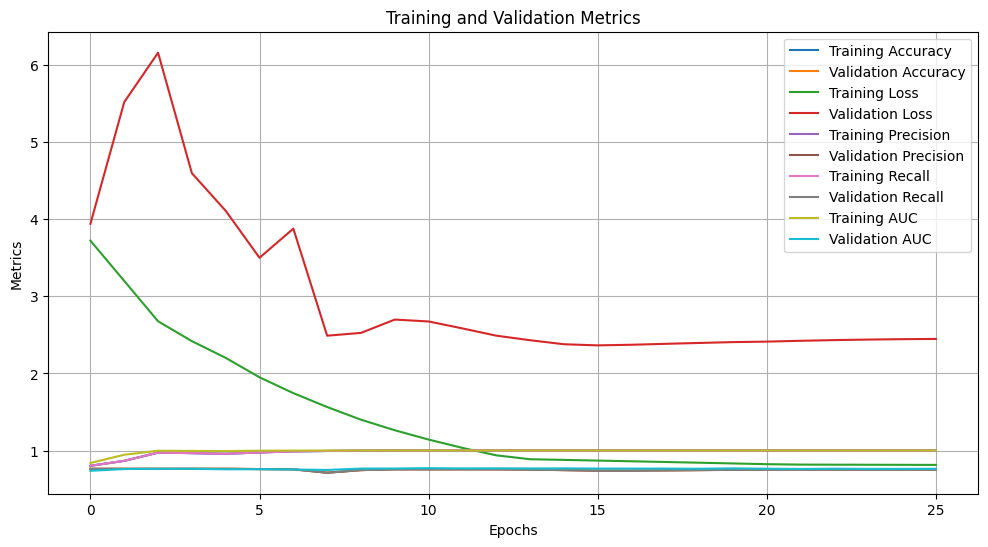

In [48]:
# Plot training history
plt.figure(figsize=(12, 6))
plt.plot(history_dict['accuracy'], label='Training Accuracy')
plt.plot(history_dict['val_accuracy'], label='Validation Accuracy')
plt.plot(history_dict['loss'], label='Training Loss')
plt.plot(history_dict['val_loss'], label='Validation Loss')
plt.plot(history_dict['precision'], label='Training Precision')
plt.plot(history_dict['val_precision'], label='Validation Precision')
plt.plot(history_dict['recall'], label='Training Recall')
plt.plot(history_dict['val_recall'], label='Validation Recall')
plt.plot(history_dict['auc'], label='Training AUC')
plt.plot(history_dict['val_auc'], label='Validation AUC')
plt.xlabel('Epochs')
plt.ylabel('Metrics')
plt.legend()
plt.title('Training and Validation Metrics')
plt.grid(True)
plt.savefig('training_history_plot.png')
plt.show()


In [49]:
# Print training and validation metrics as text
for epoch in range(len(history_dict['loss'])):
    print(f"Epoch {epoch + 1}:")
    print(f"  Training Loss: {history_dict['loss'][epoch]}")
    print(f"  Training Accuracy: {history_dict['accuracy'][epoch]}")
    print(f"  Training Precision: {history_dict['precision'][epoch]}")
    print(f"  Training Recall: {history_dict['recall'][epoch]}")
    print(f"  Training AUC: {history_dict['auc'][epoch]}")
    print(f"  Validation Loss: {history_dict['val_loss'][epoch]}")
    print(f"  Validation Accuracy: {history_dict['val_accuracy'][epoch]}")
    print(f"  Validation Precision: {history_dict['val_precision'][epoch]}")
    print(f"  Validation Recall: {history_dict['val_recall'][epoch]}")
    print(f"  Validation AUC: {history_dict['val_auc'][epoch]}")
    print("---------------------------------------------------")



Epoch 1:
  Training Loss: 3.7213082313537598
  Training Accuracy: 0.8015267252922058
  Training Precision: 0.8015267252922058
  Training Recall: 0.8015267252922058
  Training AUC: 0.8382529616355896
  Validation Loss: 3.9403014183044434
  Validation Accuracy: 0.7627118825912476
  Validation Precision: 0.7627118825912476
  Validation Recall: 0.7627118825912476
  Validation AUC: 0.7366848587989807
---------------------------------------------------
Epoch 2:
  Training Loss: 3.199613332748413
  Training Accuracy: 0.8659881353378296
  Training Precision: 0.8659881353378296
  Training Recall: 0.8659881353378296
  Training AUC: 0.9450315237045288
  Validation Loss: 5.518272876739502
  Validation Accuracy: 0.7627118825912476
  Validation Precision: 0.7627118825912476
  Validation Recall: 0.7627118825912476
  Validation AUC: 0.759494423866272
---------------------------------------------------
Epoch 3:
  Training Loss: 2.6760523319244385
  Training Accuracy: 0.9728583693504333
  Training Preci

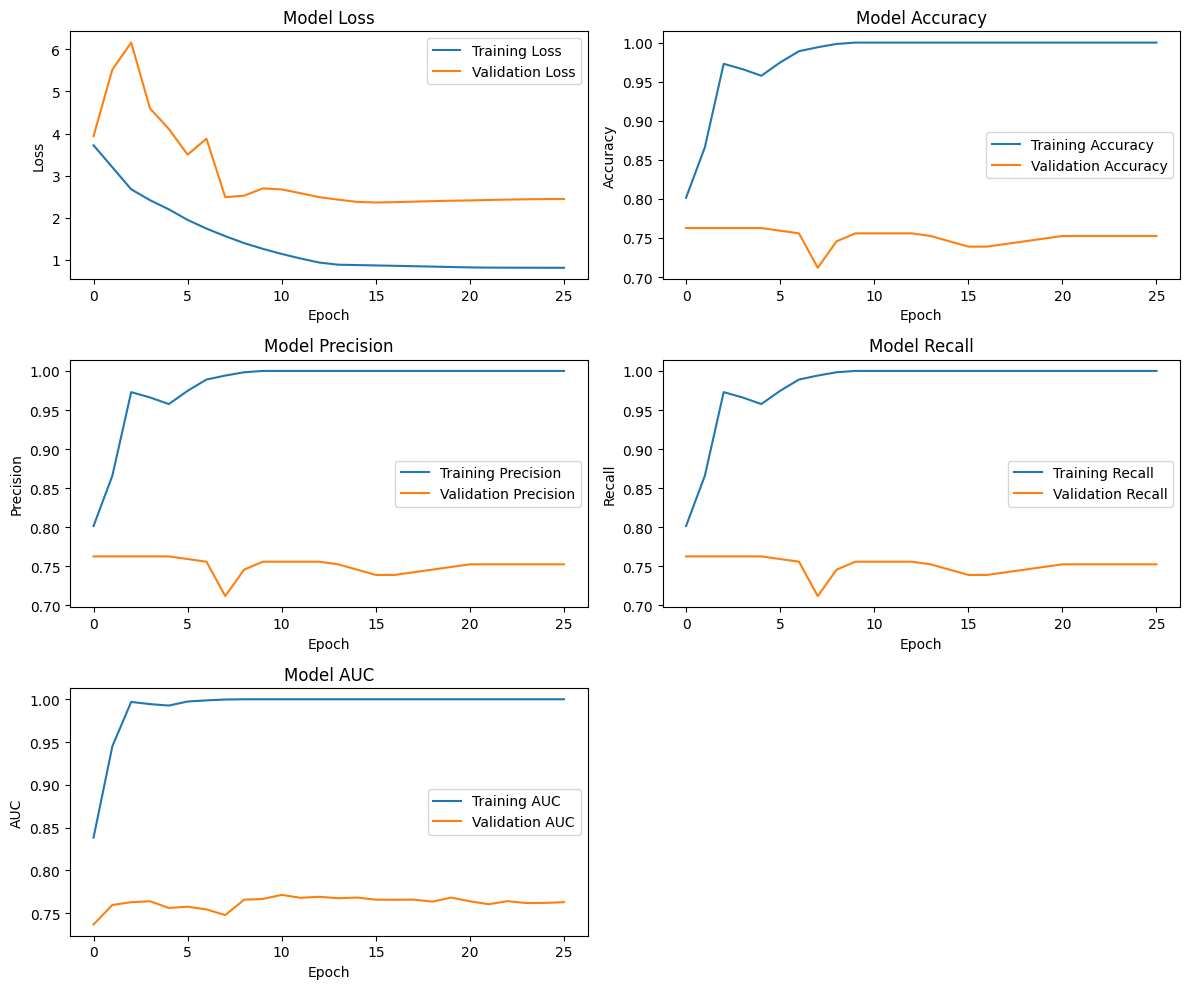

In [50]:
# Plot the Metrics
plt.figure(figsize=(12, 10))

# Loss
plt.subplot(3, 2, 1)
plt.plot(history_dict['loss'], label='Training Loss')
plt.plot(history_dict['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Accuracy
plt.subplot(3, 2, 2)
plt.plot(history_dict['accuracy'], label='Training Accuracy')
plt.plot(history_dict['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Precision
plt.subplot(3, 2, 3)
plt.plot(history_dict['precision'], label='Training Precision')
plt.plot(history_dict['val_precision'], label='Validation Precision')
plt.title('Model Precision')
plt.xlabel('Epoch')
plt.ylabel('Precision')
plt.legend()

# Recall (Sensitivity)
plt.subplot(3, 2, 4)
plt.plot(history_dict['recall'], label='Training Recall')
plt.plot(history_dict['val_recall'], label='Validation Recall')
plt.title('Model Recall')
plt.xlabel('Epoch')
plt.ylabel('Recall')
plt.legend()

# AUC
plt.subplot(3, 2, 5)
plt.plot(history_dict['auc'], label='Training AUC')
plt.plot(history_dict['val_auc'], label='Validation AUC')
plt.title('Model AUC')
plt.xlabel('Epoch')
plt.ylabel('AUC')
plt.legend()

plt.tight_layout()
plt.show()

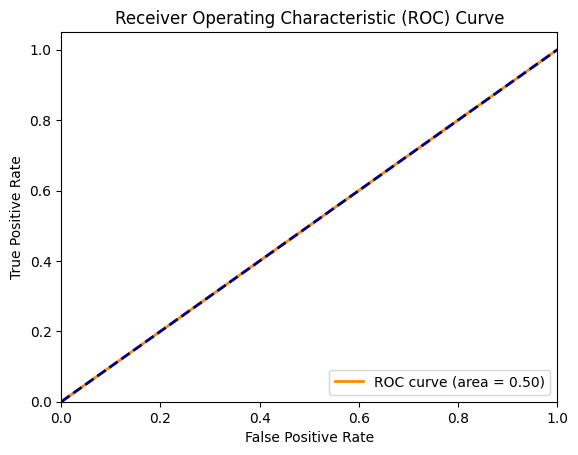

In [24]:
# Plot ROC curve for test data
from sklearn.metrics import roc_curve, auc
import numpy as np

fpr, tpr, _ = roc_curve(np.argmax(y_test, axis=1), np.argmax(predictions, axis=1))
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:0.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

==END==